In [1]:
import os, warnings
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter
from typing import Tuple
warnings.simplefilter('ignore', FutureWarning)

In [26]:
pth = os.path.join('..', '..')
pth_data = os.path.join(pth, 'data')
pth_in = os.path.join(pth_data, 'TCGA')
pth_feat = os.path.join(pth_data, 'features', 'biomart')
pth_ref = os.path.join(pth_data, 'refs')
# pth_out = ...

In [46]:
adata = sc.read_h5ad(os.path.join(pth_in, 'PANCAN.h5ad'))
# adata = adata[adata.obs['cancer type abbreviation'].isin(['LGG'])]
adata

AnnData object with n_obs × n_vars = 10535 × 60498
    obs: '_PATIENT', 'cancer type abbreviation', 'age_at_initial_pathologic_diagnosis', 'gender', 'race', 'ajcc_pathologic_tumor_stage', 'clinical_stage', 'histological_type', 'histological_grade', 'initial_pathologic_dx_year', 'menopause_status', 'birth_days_to', 'vital_status', 'tumor_status', 'last_contact_days_to', 'death_days_to', 'cause_of_death', 'new_tumor_event_type', 'new_tumor_event_site', 'new_tumor_event_site_other', 'new_tumor_event_dx_days_to', 'treatment_outcome_first_course', 'margin_status', 'residual_tumor', 'OS', 'OS.time', 'DSS', 'DSS.time', 'DFI', 'DFI.time', 'PFI', 'PFI.time', 'Redaction'
    uns: 'log1p'

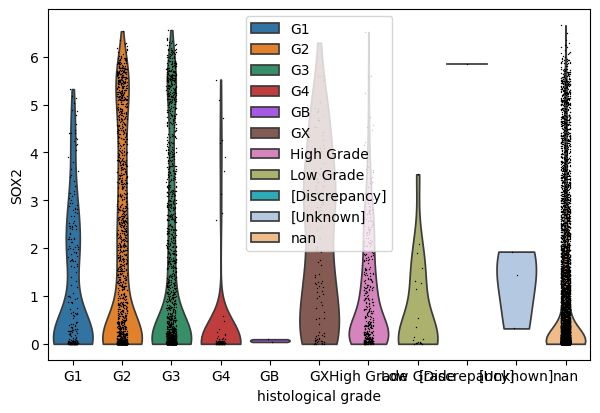

In [47]:
sc.pl.violin(adata, 'SOX2', 'histological_grade')

In [43]:
df = pd.read_csv(os.path.join(pth_feat, 'union.csv'))
tf = pd.read_csv(os.path.join(pth_ref, 'Mus_musculus_TF'), sep = '\t')
genes = df.hsapiens.loc[df.mmusculus.isin(tf.Symbol) & df.hsapiens.isin(adata.var_names)]
genes = genes.loc[adata[:, genes].X.toarray().mean(axis = 0) > 0].values.tolist()

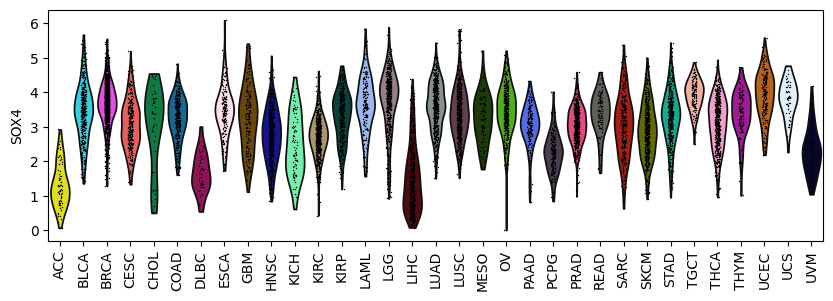

In [4]:
plt.figure(figsize = (10, 3))
sc.pl.violin(adata, 'SOX4', 'cancer type abbreviation', rotation = 90, ax = plt.gca(), show = False)
plt.legend().set_visible(False)
plt.show()

In [5]:
# cancer_types_dict = {
#     'ACC'  : 'Adrenocortical Cancer',
#     'BLCA' : 'Bladder Cancer',
#     'BRCA' : 'Breast Cancer',
#     'CESC' : 'Cervical Cancer',
#     'CHOL' : 'Bile Duct Cancer',
#     'COAD' : 'Colon Cancer',
#     'DLBC' : 'Large B-cell Lymphoma',
#     'ESCA' : 'Esophageal Cancer',
#     'GBM'  : 'Glioblastoma',
#     'HNSC' : 'Head and Neck Cancer',
#     'KICH' : 'Kidney Chromophobe',
#     'KIRC' : 'Kidney Clear Cell Carcinoma',
#     'KIRP' : 'Kidney Papillary Cell Carcinoma',
#     'LAML' : 'Acute Myeloid Leukemia',
#     'LGG'  : 'Lower Grade Glioma',
#     'LIHC' : 'Liver Cancer',
#     'LUAD' : 'Lung Adenocarcinoma',
#     'LUSC' : 'Lung Squamous Cell Carcinoma',
#     'MESO' : 'Mesothelioma',
#     'OV'   : 'Ovarian Cancer',
#     'PAAD' : 'Pancreatic Cancer',
#     'PCPG' : 'Pheochromocytoma & Paraganglioma',
#     'PRAD' : 'Prostate Cancer',
#     'READ' : 'Rectal Cancer',
#     'SARC' : 'Sarcoma',
#     'SKCM' : 'Melanoma',
#     'STAD' : 'Stomach Cancer',
#     'TGCT' : 'Testicular Cancer',
#     'THCA' : 'Thyroid Cancer',
#     'THYM' : 'Thymoma',
#     'UCEC' : 'Endometrioid Cancer',
#     'UCS'  : 'Uterine Carcinosarcoma',
#     'UVM'  : 'Ocular Melanomas'}

survival_types_dict = {
    'OS'  : 'Overall Survival',
    'DSS' : 'Disease-Specific Survival',
    'DFI' : 'Disease-Free Interval',
    'PFI' : 'Progresssion-Free Interval'}

In [12]:
from typing import List

def fit_survival(adata: ad.AnnData,
                 genes: List[str],
                 survival_type: str,
                 ) -> plt.Axes:

    # select cancer type & gene
    df = adata.obs.copy()
    df[genes] = adata[:, genes].X.toarray()

    # deduplicate patients
    survival_type_time = survival_type + '.time'
    agg_dict = {survival_type      : 'first',
                survival_type_time : 'first'}
    for g in genes: agg_dict[g] = 'mean'
    cols = list(agg_dict.keys())
    df[cols] = df[cols].astype(float)
    agg_dict['cancer type abbreviation'] = 'first'
    df = df.groupby('_PATIENT').agg(agg_dict).dropna(subset = list(agg_dict.keys()))
    df['cancer type abbreviation'] = df['cancer type abbreviation'].astype(str)
    df[survival_type_time] /= 365.

    cph = CoxPHFitter()
    cph.fit(df,
            survival_type_time,
            event_col = survival_type,
            strata = 'cancer type abbreviation')
    ax = cph.plot()
    return ax

OS


/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

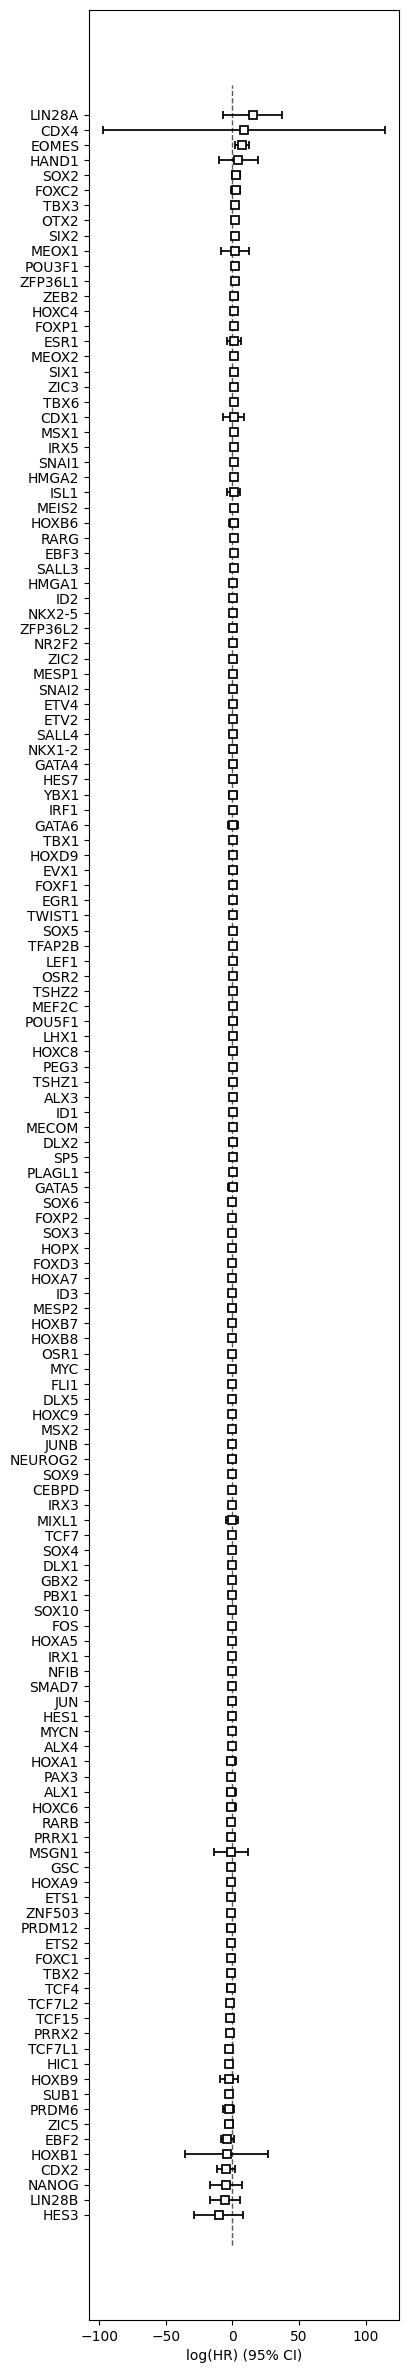

DSS


/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

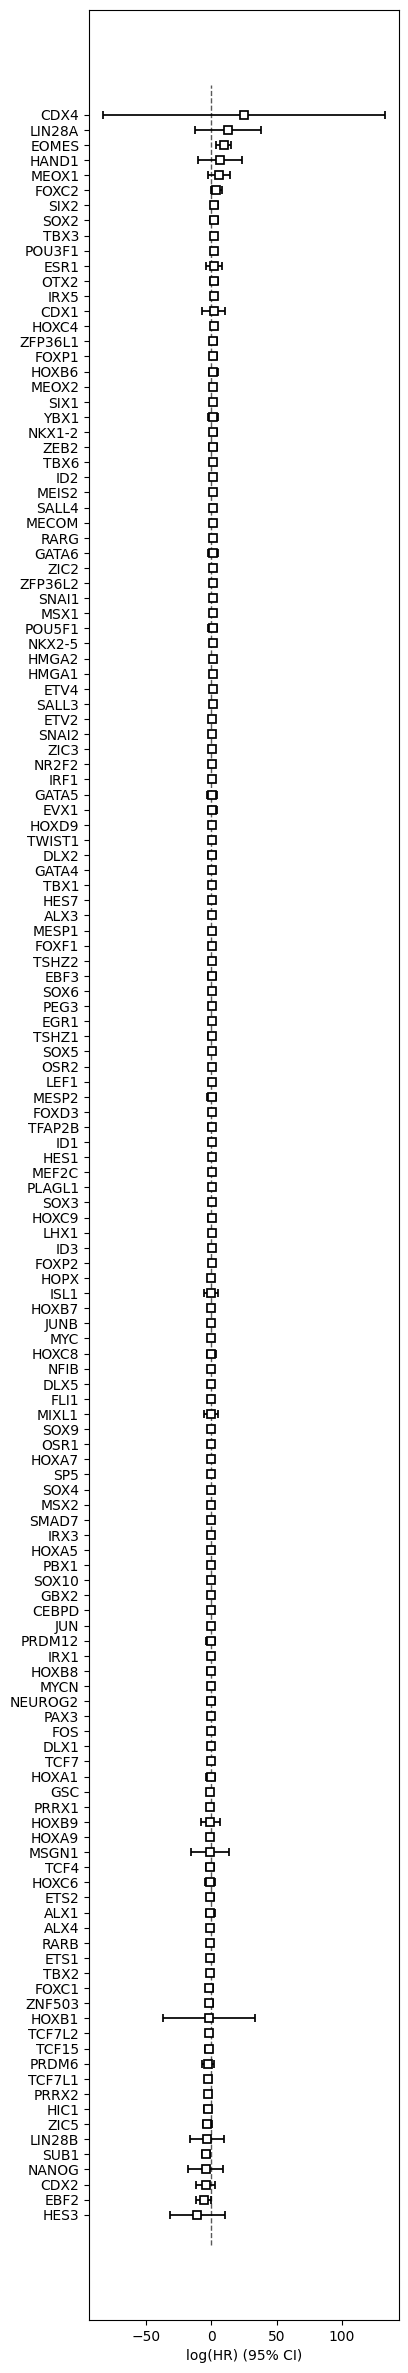

DFI


/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[genes] = adata[:, genes].X.toarray()
/tmp/ipykernel_1534695/1367804889.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

ConvergenceError: Convergence halted due to matrix inversion problems. Suspicion is high collinearity. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-modelMatrix is singular.

<Figure size 400x3000 with 0 Axes>

In [44]:
# genes = ['SOX4', 'SNAI1', 'SNAI2', 'FOXC1', 'TWIST1', 'TWIST2', 'ZEB1', 'ZEB2']
for survival_type, survival_name in survival_types_dict.items():
    print(survival_type)
    plt.figure(figsize = (4, 30))
    ax = fit_survival(adata, genes, survival_type)
    plt.show()